# **SETUP**

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import os, json, time
#from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import randint

RANDOM_SEED = 42

# **Carga de datos**

In [53]:
def load_data(filepath):
  data = pd.read_csv(filepath)
  return data

# **Exploración de datos**

In [54]:
def show_data(df):
  print("-------------------- DATA INFORMATION ------------------")
  df.info()
  print("---------------------------------------------------------")
  display(df.head())

def check_duplicated_index(data):
  print(f'Are there duplicates? {data.index.duplicated().any()}')
  print(f'If so, how many? {data.index.duplicated().sum()}')

# **Limpieza basica de datos**

In [55]:
def clean_data(data):
  df = data

  #Eliminamos registros con valores nulos
  df = df.dropna()

  df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

  #Eliminamos registros cuyo valor sea ?
  df = df[~df.isin(['?']).any(axis=1)]

  #Eliminamos registros cuyo valor sea error
  df = df[~df.isin(['error']).any(axis=1)]

  #Eliminamos registros cuyo valor sea NAN
  df = df[~df.isin(['NAN']).any(axis=1)]

  #Eliminamos registros cuyo valor sea invalid
  df = df[~df.isin(['invalid']).any(axis=1)]

  #Eliminamos registros cuyo valor sea invalid
  df = df[~df.isin(['null']).any(axis=1)]

  #Eliminamos espacios extra
  df['DateTime'] = df['DateTime'].str.strip()

  return df



def delete_columns(data, cols):
  #Eliminamos las columnas
  data = data.drop(columns=cols)
  return data


def convert_numeric_columns(data, cols):
  # Intentar convertir cada una a numérico
  for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    #df_org[col] = df_org[col].apply(lambda x: '{:.4f}'.format(x) if pd.notnull(x) else '')
  return data

def convert_datetime(data, cols):
  for col in cols:
    data[col] = pd.to_datetime(data[col])
  return data


def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

# **Visualización de datos**

In [56]:
def show_line_plot(df, cols):
  plt.gca().ticklabel_format(style='plain', axis='y')
  for zone in cols:
      sns.lineplot(x=df.index,
                  y=zone,
                  data=df,
                  label=zone,
                  alpha=0.8)
  plt.title("LINE PLOT", fontsize=20, fontweight='bold')
  plt.legend()


def show_boxplot(df, cols, y_label):
  fig, axes = plt.subplots(1, 3, figsize=(21,7), sharey=True)

  for i,zone in enumerate(cols):
    sns.boxplot( y=zone, data=df, ax=axes[i])
    axes[i].set_title(f'{zone}')
    axes[i].set_ylabel(y_label)

    # Desactivar notación científica en el eje y
    axes[i].yaxis.set_major_formatter(ScalarFormatter())
    axes[i].ticklabel_format(style='plain', axis='y')

  fig.suptitle("BOX PLOT", fontsize=22, fontweight='bold', y=1.02)
  plt.tight_layout()
  plt.show()

def show_kdeplot(df, cols, xlabel, ylabel, title):
  plt.figure(figsize=(15,8))
  plt.gca().ticklabel_format(style='plain', axis='x')
  for col in cols:
    sns.kdeplot(df[col], label=col, fill=True, alpha=0.4)
  plt.xlim(0, 100000)  # Aquí defines el límite inferior y superior del eje x

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

def show_corr(df, title):
  corr = df.corr()
  sns.heatmap(corr, annot=True, fmt=".2f", cmap="PiYG", cbar=True)
  plt.title(title, fontsize=14, pad=15)
  plt.show()

def show_scatterplot(df, cols1, cols2, ylabel):
  for col in cols1:
    plt.figure(figsize=(15,7))

    for col2 in cols2:
      sns.scatterplot(x=col, y=col2, data=df, label=col2, alpha=0.8)

    plt.title(f"Relationship between {col} and {ylabel}")
    plt.xlabel(col)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xlim(0, 80)
    plt.show()

# **Training**

In [57]:
def split_dataset(df, target, cols, test_size=0.2, random_state=42):
  X = df.drop(columns= cols, errors="ignore")
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  return X_train, X_test, y_train, y_test

def column_transformer(df, target, cols):
  X = df.drop(columns= cols, errors="ignore")
  y = df[target]
  num_cols = selector(dtype_include=np.number)(X)
  cat_cols = selector(dtype_exclude=np.number)(X)

  prep = ColumnTransformer([
      ("num", StandardScaler(), num_cols),
      ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
  ])

  return prep

def training_models(xtrain,xtest,ytrain,ytest):
  models = {
    "Linear": Pipeline([("prep", prep), ("model", LinearRegression())]),
    "Ridge": Pipeline([("prep", prep), ("model", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("prep", prep), ("model", Lasso(alpha=0.001, max_iter=5000))]),
    "RandomForest": Pipeline([
        ("prep", prep),
        ("model", RandomForestRegressor(n_estimators=120, max_depth=12, random_state=RANDOM_SEED))
    ])
  }

  results = []

  for name, pipe in models.items():
      pipe.fit(xtrain, ytrain)
      pred = pipe.predict(xtest)
      mae = mean_absolute_error(ytest, pred)
      mse = mean_squared_error(ytest, pred)
      rmse = np.sqrt(mse)
      r2 = r2_score(ytest, pred)

      results.append([name, mae, rmse, r2])
  return results

def importances(df, best_model, X_test, y_test, cols):
  X = df.drop(columns= cols, errors="ignore")
  pi = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
  importances = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)
  importances.head(10).plot(kind='barh', title='Top 10 variables más importantes', figsize=(8,5))
  return importances

# **MAIN**

In [58]:
original_data = load_data('../data/raw/power_tetouan_city_modified.csv')
print("---------------------- ORIGINAL DATA ----------------------------")
show_data(original_data)

---------------------- ORIGINAL DATA ----------------------------
-------------------- DATA INFORMATION ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53464 entries, 0 to 53463
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DateTime                   52977 non-null  object
 1   Temperature                52880 non-null  object
 2   Humidity                   52826 non-null  object
 3   Wind Speed                 52846 non-null  object
 4   general diffuse flows      52838 non-null  object
 5   diffuse flows              52849 non-null  object
 6   Zone 1 Power Consumption   52861 non-null  object
 7   Zone 2  Power Consumption  52839 non-null  object
 8   Zone 3  Power Consumption  52889 non-null  object
 9   mixed_type_col             48162 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB
---------------------------------------------------------


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,NaN,34055.6962,16128.87538,20240.96386,624
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879


In [59]:
#Realizamos limpieza de datos
cleaned_data = clean_data(original_data)

#Borramos las columnas que no necesitamos
del_columns_arr = ['mixed_type_col']
cleaned_data = delete_columns(cleaned_data, del_columns_arr)

cols_numericas = ['Temperature', 'Humidity', 'Wind Speed',
                  'general diffuse flows', 'diffuse flows',
                  'Zone 1 Power Consumption', 'Zone 2  Power Consumption',
                  'Zone 3  Power Consumption']


cleaned_data = convert_numeric_columns(cleaned_data, cols_numericas)

#Mostramos los datos limpios
print("---------------------- CLEANED DATA ----------------------------")
show_data(cleaned_data)

#Guardamos un nuevo archivo con datos limpios
cleaned_data.to_csv('../data/processed/power_tetouan_city_clean.csv')

---------------------- CLEANED DATA ----------------------------
-------------------- DATA INFORMATION ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 42300 entries, 1 to 53463
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   42300 non-null  object 
 1   Temperature                42292 non-null  float64
 2   Humidity                   42296 non-null  float64
 3   Wind Speed                 42296 non-null  float64
 4   general diffuse flows      42295 non-null  float64
 5   diffuse flows              42292 non-null  float64
 6   Zone 1 Power Consumption   42295 non-null  float64
 7   Zone 2  Power Consumption  42294 non-null  float64
 8   Zone 3  Power Consumption  42292 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.2+ MB
---------------------------------------------------------


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
5,1/1/2017 0:50,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048


In [60]:
cleaned_data = load_data('../data/processed/power_tetouan_city_clean.csv')

cols_datetime = ['DateTime']
cleaned_data = convert_datetime(cleaned_data, cols_datetime)

cleaned_data = cleaned_data.set_index('DateTime')

show_data(cleaned_data)

-------------------- DATA INFORMATION ------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42300 entries, 2017-01-01 00:10:00 to 2017-07-08 05:20:00
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 42300 non-null  int64  
 1   Temperature                42292 non-null  float64
 2   Humidity                   42296 non-null  float64
 3   Wind Speed                 42296 non-null  float64
 4   general diffuse flows      42295 non-null  float64
 5   diffuse flows              42292 non-null  float64
 6   Zone 1 Power Consumption   42295 non-null  float64
 7   Zone 2  Power Consumption  42294 non-null  float64
 8   Zone 3  Power Consumption  42292 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 3.2 MB
---------------------------------------------------------


,Unnamed: 0,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,,
2017-01-01 00:10:00,1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
2017-01-01 00:50:00,5,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048


In [61]:
column_to_delete_arr = ['Unnamed: 0']

cleaned_data = delete_columns(cleaned_data, column_to_delete_arr)

show_data(cleaned_data)

-------------------- DATA INFORMATION ------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42300 entries, 2017-01-01 00:10:00 to 2017-07-08 05:20:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                42292 non-null  float64
 1   Humidity                   42296 non-null  float64
 2   Wind Speed                 42296 non-null  float64
 3   general diffuse flows      42295 non-null  float64
 4   diffuse flows              42292 non-null  float64
 5   Zone 1 Power Consumption   42295 non-null  float64
 6   Zone 2  Power Consumption  42294 non-null  float64
 7   Zone 3  Power Consumption  42292 non-null  float64
dtypes: float64(8)
memory usage: 2.9 MB
---------------------------------------------------------


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048


In [62]:
check_duplicated_index(cleaned_data)

Are there duplicates? True
If so, how many? 628


In [63]:
cleaned_data[cleaned_data.index.duplicated(keep=False)].sort_index()
cleaned_data = cleaned_data[~cleaned_data.index.duplicated(keep='first')]

check_duplicated_index(cleaned_data)

Are there duplicates? False
If so, how many? 0


In [64]:
cleaned_data.rename(columns={
    'Temperature': 'temp',
    'Humidity':'hum',
    'Wind Speed':'wind',
    'general diffuse flows':'gen_diffuse_flows',
    'diffuse flows':'diffuse_flows',
    'Zone 1 Power Consumption':'z1_power_cons',
    'Zone 2  Power Consumption':'z2_power_cons',
    'Zone 3  Power Consumption':'z3_power_cons',
}, inplace=True)

features = ['temp','hum','wind','gen_diffuse_flows','diffuse_flows',
             'z1_power_cons','z2_power_cons','z3_power_cons']

cleaned_data = remove_outliers_iqr(cleaned_data, features)

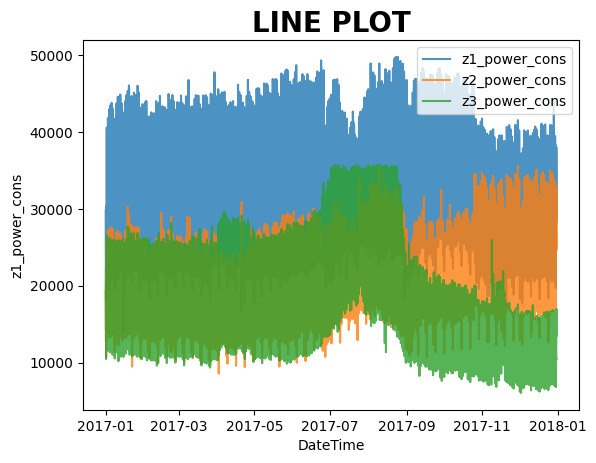

In [65]:
categories = ['z1_power_cons','z2_power_cons','z3_power_cons']
weather_feature = ['temp','hum','wind']

#----------------------------------------------------------------
#---------------------- LINEPLOT --------------------------------
#----------------------------------------------------------------
show_line_plot(cleaned_data, categories)

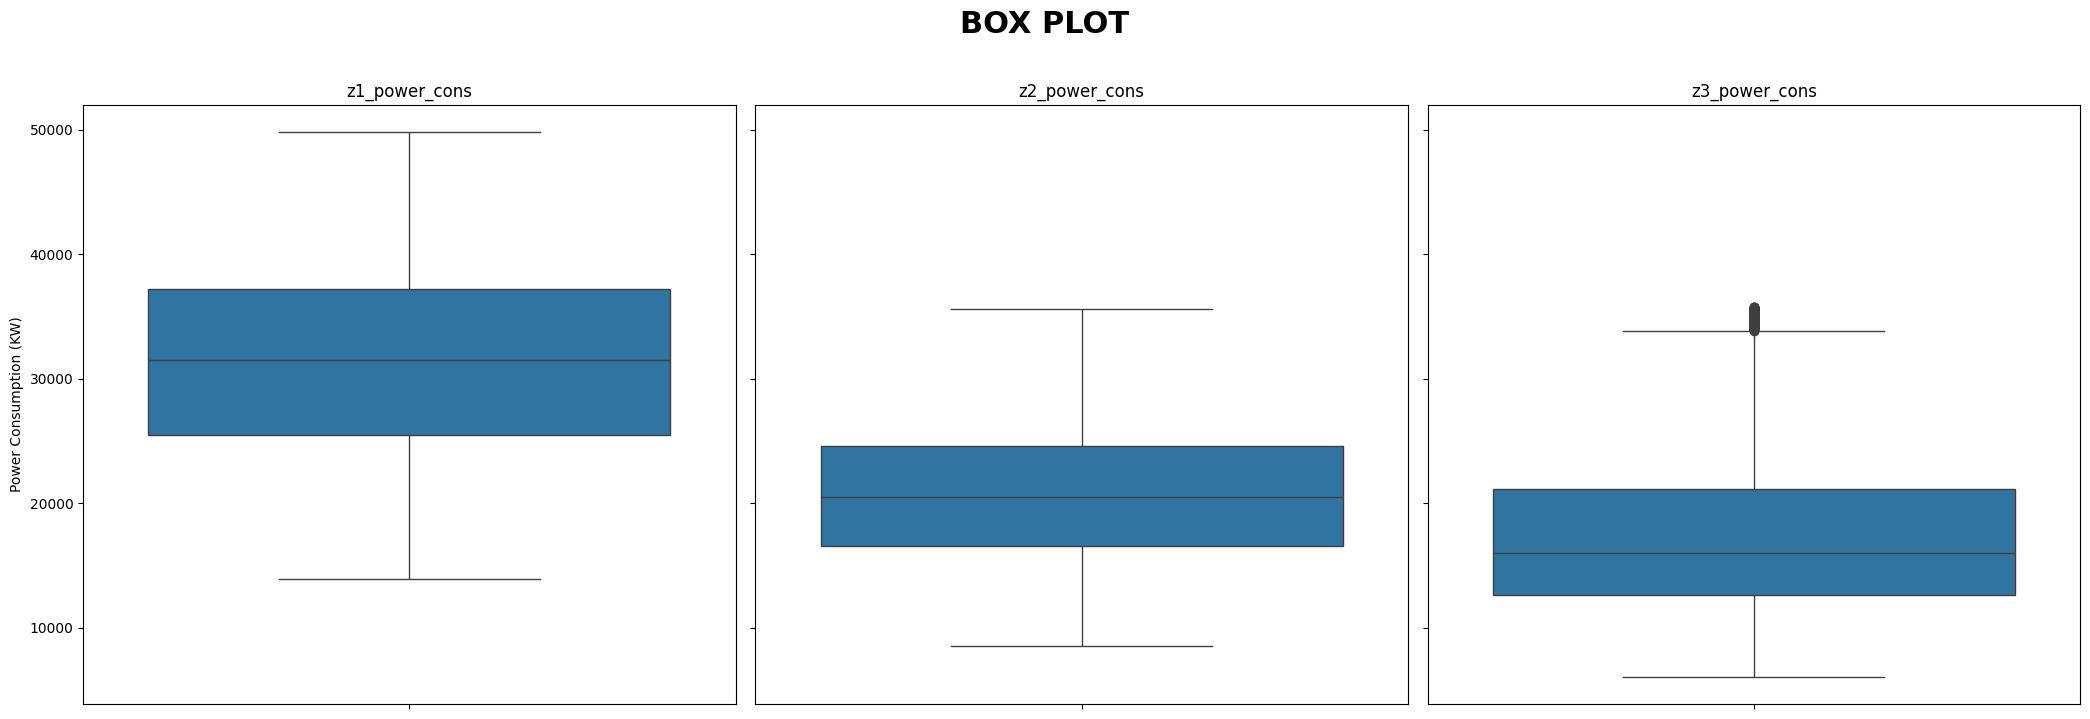

In [66]:
#----------------------------------------------------------------
#---------------------- BOXPLOT --------------------------------
#----------------------------------------------------------------
show_boxplot (cleaned_data, categories, 'Power Consumption (KW)')

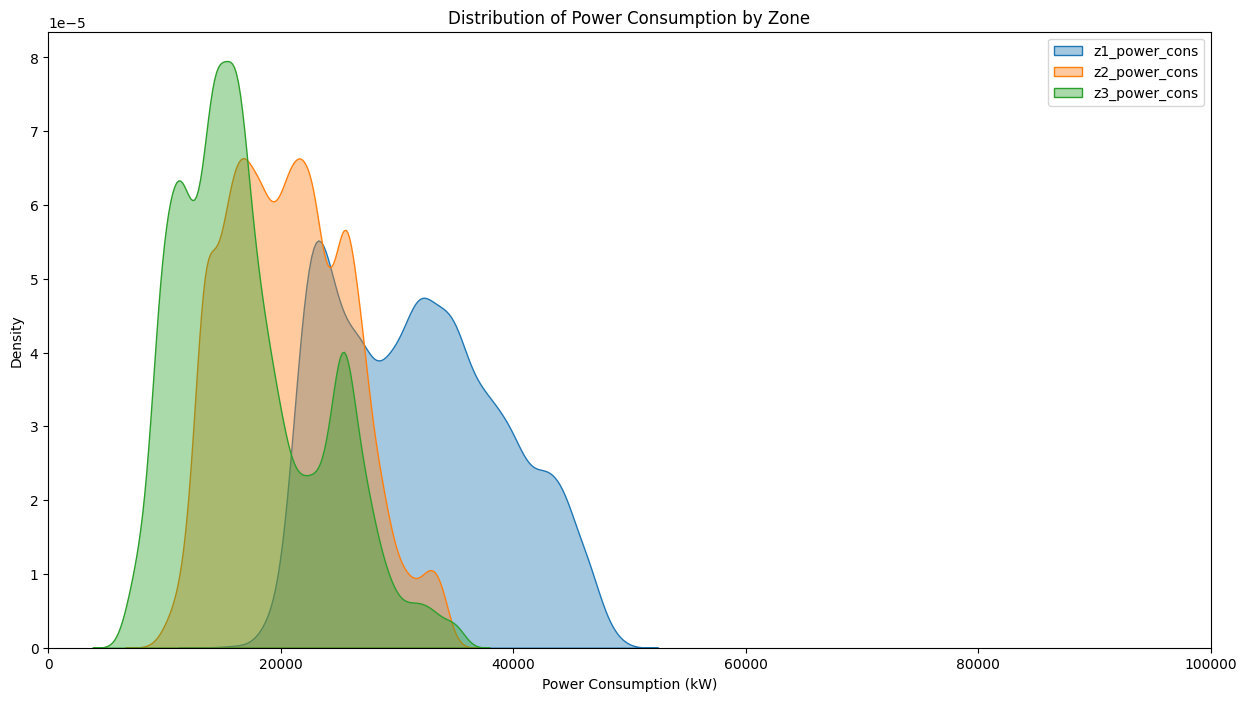

In [67]:
#----------------------------------------------------------------
#---------------------- KDEPLOT --------------------------------
#----------------------------------------------------------------
show_kdeplot(cleaned_data, categories, 'Power Consumption (kW)', 'Density', 'Distribution of Power Consumption by Zone')

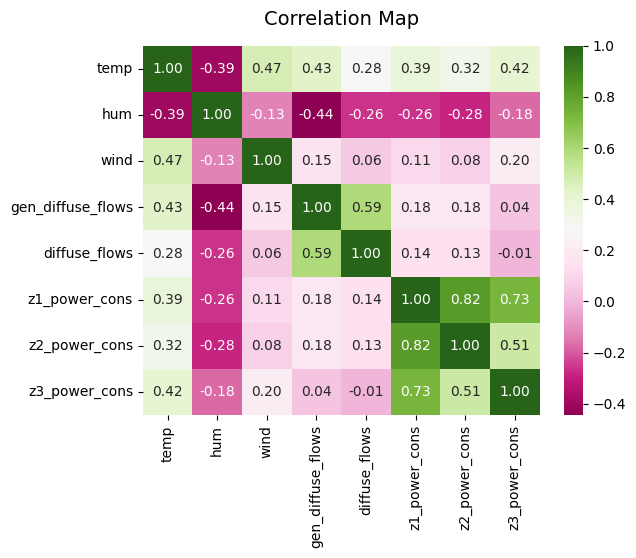

In [68]:
#----------------------------------------------------------------
#---------------------- CORRELATION -----------------------------
#----------------------------------------------------------------
show_corr(cleaned_data, "Correlation Map")

In [69]:
# New columns
cleaned_data['hour'] = cleaned_data.index.hour
cleaned_data['day_of_week'] = cleaned_data.index.dayofweek  # Monday=0, Sunday=6
cleaned_data['month'] = cleaned_data.index.month
cleaned_data['day'] = cleaned_data.index.day

In [70]:
#Guardamos un nuevo archivo con datos limpios
cleaned_data.to_csv('../data/final/power_tetouan_city_after_EDA.csv')

In [71]:
final_data = load_data('../data/final/power_tetouan_city_after_EDA.csv')

In [72]:
#Define target an xcolumns
target = "z1_power_cons"
x_columns = [target, 'DateTime']

#Split dataset
X_train, X_test, y_train, y_test = split_dataset(final_data, target, x_columns, 0.2, RANDOM_SEED)
print("Dataset cargado correctamente:", final_data.shape)
final_data.head()

Dataset cargado correctamente: (33770, 13)


,DateTime,temp,hum,wind,gen_diffuse_flows,diffuse_flows,z1_power_cons,z2_power_cons,z3_power_cons,hour,day_of_week,month,day
0,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1
1,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1
2,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1
3,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1
4,2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048,0,6,1,1


In [73]:
# -------------------------------------------------------------
# ---------------- Column transformer -------------------------
# -------------------------------------------------------------
prep = column_transformer(final_data, target, x_columns)

In [74]:
# -------------------------------------------------------------
# ---------------  Baseline Models ----------------------------
# -------------------------------------------------------------
results = training_models(X_train, X_test, y_train, y_test)

baseline = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R2"]).sort_values("R2", ascending=False)
baseline


,Modelo,MAE,RMSE,R2
3,RandomForest,677.097302,988.642705,0.981255
0,Linear,2075.828750,2685.110994,0.861727
2,Lasso,2075.828948,2685.111014,0.861727
1,Ridge,2075.835655,2685.112158,0.861727


In [75]:
# -------------------------------------------------------------
# --------------- Hyperparameter tuning -----------------------
# -------------------------------------------------------------

rf_pipe = Pipeline([("prep", prep), ("model", RandomForestRegressor(random_state=RANDOM_SEED))])
rf_param = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": randint(4, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 8)
}
rf_search = RandomizedSearchCV(rf_pipe, rf_param, n_iter=15, scoring="r2", cv=3, n_jobs=-1, random_state=RANDOM_SEED)
rf_search.fit(X_train, y_train)

ridge_pipe = Pipeline([("prep", prep), ("model", Ridge())])
ridge_grid = {"model__alpha": [0.1, 1.0, 10.0, 100.0]}
ridge_search = GridSearchCV(ridge_pipe, ridge_grid, scoring="r2", cv=3, n_jobs=-1)
ridge_search.fit(X_train, y_train)

rf_best, ridge_best = rf_search.best_estimator_, ridge_search.best_estimator_

pd.DataFrame([
    {"Modelo": "RandomForest (tuned)", "R2": r2_score(y_test, rf_best.predict(X_test))},
    {"Modelo": "Ridge (tuned)", "R2": r2_score(y_test, ridge_best.predict(X_test))}
])


,Modelo,R2
0,RandomForest (tuned),0.986206
1,Ridge (tuned),0.861727


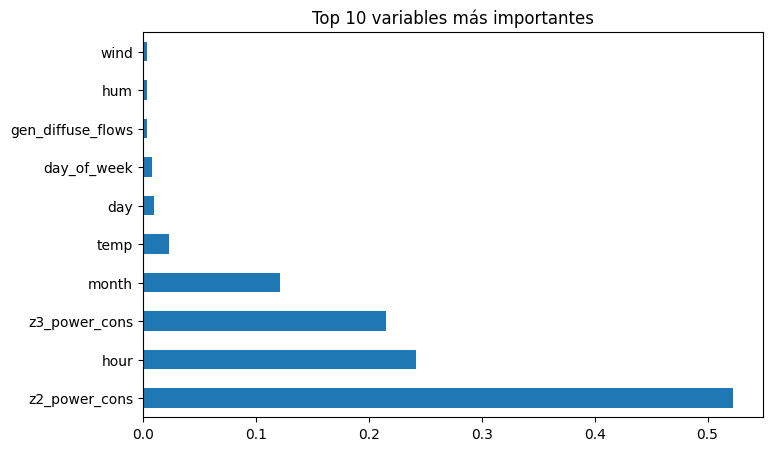

In [76]:
#Importancia de variables
importances = importances(final_data, rf_best, X_test, y_test, x_columns)

In [77]:
#Guardamos los archivos de salida
importances.to_csv('../data/final/feature_importance.csv')
baseline.to_csv("../data/final/baseline.csv", index=False)
print("Archivos guardados en carpeta 'data/final/'")

Archivos guardados en carpeta 'data/final/'
